<a href="https://colab.research.google.com/github/Weverton-Vitor/car-counting-yolo/blob/main/Counting_car_using_YOLO_and_Super_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Counting car using YOLO and Super Vision

In [2]:
# Check the GPU
!nvidia-smi

Wed Sep 18 00:42:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 22.0 MB/s eta 0:00:00


In [4]:
from IPython import display
import os

In [5]:
# Set the home directory
HOME = os.getcwd()
print(HOME)

/content


## Download Video

In [6]:
!pip install -q gdown
%cd {HOME}

/content


In [7]:
!gdown '1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

Downloading...
From: https://drive.google.com/uc?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
To: /content/vehicle-counting.mp4
100% 35.3M/35.3M [00:01<00:00, 30.2MB/s]


In [8]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

## Install YOLOv8

In [9]:
!pip install ultralytics
display.clear_output()

In [10]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.9/112.6 GB disk)


## Intall Roboflow Super Vision

Super Vision is lib that's have a bunch of reusable tools of computer vision: https://github.com/roboflow/supervision?ref=blog.roboflow.com

In [11]:
!pip install supervision
display.clear_output()

## Load pre-trained YOLOv8 model

In [12]:
MODEL = "yolov8x.pt"

In [13]:
from ultralytics import YOLO

# Create the yolo class object
model = YOLO(MODEL)

# Fuse some model's layers to optimize the model
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 336MB/s]


YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


## Predict and annotate single frame

In [14]:
# Get class_name and ids
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [15]:
# Class of interest
selected_classes = [2, 3, 5, 7]

In [16]:
import numpy as np
import supervision as sv

['truck 0.93', 'car 0.90', 'car 0.86', 'car 0.78']


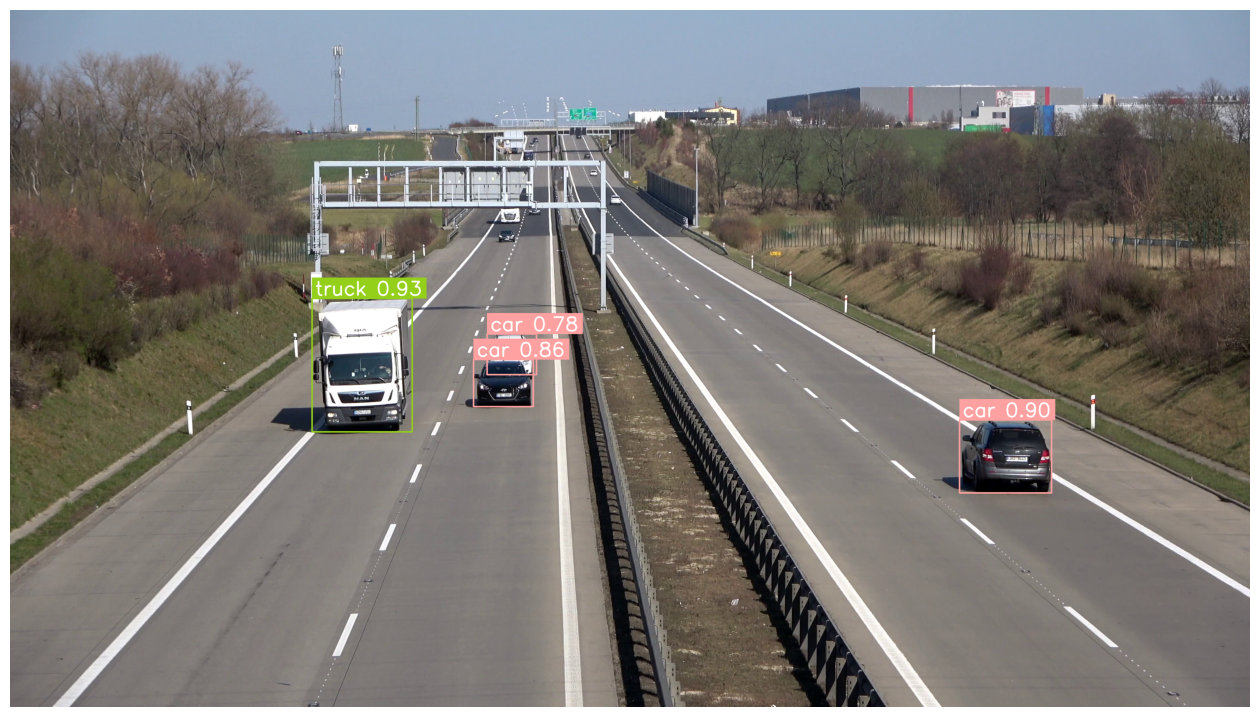

In [17]:
# Frame generator, yelds a ndarray to each video's frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# BoxAnnotator and LabelAnnotator instances
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP_LEFT, text_thickness=4, text_scale=2)

# Get first video's frame
iterator = iter(generator)
frame = next(iterator)

# print(type(frame), frame)

# Using the model to detect in a single frame
results = model(frame, verbose=False)[0] # Ultralytcs Result class
# print(type(results), results)

# Using Super Vision to get the results detection
detections = sv.Detections.from_ultralytics(results) # Only the bounding boxes and it's confidences
# print(detections)

# Customs labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]
print(labels)

# Annotate and display frame
annotated_frame = box_annotator.annotate(scene=frame, detections=detections)
annotated_frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)
%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Predict and annotate whole video

In [18]:
# Create line points using super vision
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"

In [20]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

[ByteTracker](https://docs.ultralytics.com/reference/trackers/byte_tracker/): A tracking algorithm built on top of YOLOv8 for object detection and tracking.
There are another trackers such like:
1. SORT: [SIMPLE ONLINE AND REALTIME TRACKING](https://arxiv.org/pdf/1602.00763) - [Git Hub](https://github.com/abewley/sort?tab=readme-ov-file)
2. DeepSort: [SIMPLE ONLINE AND REALTIME TRACKING WITH A DEEP ASSOCIATION METRIC](https://arxiv.org/pdf/1703.07402) - [Git Hub](https://github.com/nwojke/deep_sort?tab=readme-ov-file)
3. FairMOT: [FairMOT: On the Fairness of Detection and Re-Identification in Multiple Object Tracking ](https://arxiv.org/pdf/2004.01888)- [Git Hub](https://github.com/ifzhang/FairMOT?ref=blog.roboflow.com)

In [22]:
# Create ByteTracker instance
byte_tracker = sv.ByteTrack(track_activation_threshold=0.25, # Confidence level to activate the tracking to a detection
                            lost_track_buffer=30, #
                            minimum_matching_threshold=0.8, #
                            frame_rate=30) #

# Video infor
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create annotators
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP_LEFT, text_thickness=4, text_scale=2)

# TraceAnnotator
trace_annotation = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)